# Load all packages

In [90]:
## general
import numpy as np
import datetime
import joblib
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm
import datetime as dt


## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from scipy.optimize import curve_fit, fmin
from sklearn.preprocessing import StandardScaler
from pygam import LinearGAM, s, te, f

# statistics which aren't all that nice in python
import rpy2.robjects as robjects

## my stuff
sys.path.insert(1,'/home/snath/polybox/LAMACLIMA/')
from tools.loading import load_data_single_mod, load_data_single_mod_rh
from tools.processing import AR1_predict, compute_llh_cv,gaspari_cohn
from tools.plotting import TaylorDiagram
from tools.GBR_fit import get_data_train_gbr

## plotting
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs

##for parallelisation
from sklearn.externals.joblib import Parallel, delayed
from scipy.interpolate import griddata

## customised tools
import block_cv
import load_data
import cluster_background_climates

# Get datasets

In [87]:
## Get the Aff, Def datasets for ESMs
importlib.reload(load_data)

data={}
data_lc={}


for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
    
    print('Loading data for: ', model)
    
    data=load_data.load_data_tas(data,model)
    data_lc=load_data.load_data_lc(data_lc,model)
    
    idx_l, _, _, lon_pc, lat_pc = load_data.load_meta_data()
    

Loading data for:  Obs
Loading data for:  CESM2


/home/snath/polybox/LAMACLIMA/LCLM_module/load_data.py:119: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data[model][var] = [xr.open_mfdataset(config['main_dir']+file_path).roll(lon=72)['%s_local'%var_name].values[:,idx_l]]
/home/snath/polybox/LAMACLIMA/LCLM_module/load_data.py:119: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  data[model][var] = [xr.open_mfdataset(config['main_dir']+file_path).roll(lon=72)['%s_local'%var_name].values[:,idx_l]]
/home/snath/polybox/LAMACLIMA/LCLM_module/load_data.py:144: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
comb

Loading data for:  MPI-ESM


/home/snath/polybox/LAMACLIMA/LCLM_module/load_data.py:123: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data[model][var].append(xr.open_mfdataset(config['main_dir']+file_path.replace('frst-ctl','crop-ctl')).roll(lon=72)['%s_local'%var_name].values[:,idx_l])
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
 

Loading data for:  EC-EARTH


/home/snath/polybox/LAMACLIMA/LCLM_module/load_data.py:144: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  df = xr.open_mfdataset(config['main_dir']+config['lc_map_file_dirs'][model]).roll(lon = 72)
/home/snath/polybox/LAMACLIMA/LCLM_module/load_data.py:144: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  df = xr.open_mfdataset(config['main_dir']+config['lc_map_file_dirs'][model]).roll(lon = 72)
/home/snath/polybox/LAMACLIMA/LCLM_module/load_data.py:160: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stabl

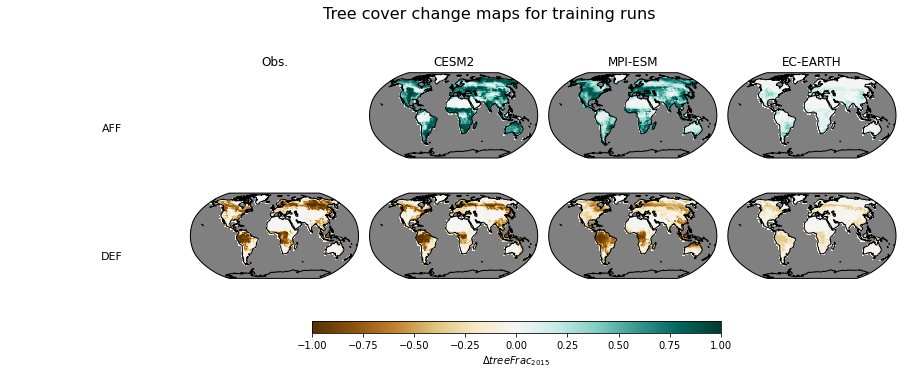

In [110]:
import matplotlib.colors as mcolors
import joblib

n_col = 4
n_row = 2

fs_title=16

fig=plt.figure(figsize=(16, 6))
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*3+5, n_col*10+10, wspace=0.2, hspace=0.2) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


axtitle=plt.subplot(grid[0,4:])
plt.title(r'Tree cover change maps for training runs',y=0.52,fontsize=16)
plt.axis('off')

bounds = [-0.05,0.05,0.15,0.35,0.65,0.85,1.15,1.85,2.15,2.85]
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)


  
i_y=1
for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
    
    i=1  
        
    for i_lab in range(2):
        
        
        if i_lab==1 and model == 'Obs':
            
            axcbar=plt.subplot(grid[7:,17:40]) 
            cbar=plt.colorbar(mesh_1,orientation='horizontal',aspect=35)
            cbar.ax.set_xlabel(r'$\Delta treeFrac_{2015}$')
            plt.axis('off')

        model_label=model
        if model=='Obs':
            model_label='Obs.'

        
        if model=='Obs':
            
            if i_lab==0:
                
                ax = plt.subplot(grid[i+1:i+4,i_y*10:i_y*10+10])
                ax.set_title(model_label,y=1.02,fontsize=12)
                plt.axis('off')
                
                i+=4
                continue
        
            elif i_lab==1:
                y_ma = np.zeros(idx_l.shape)
                y_ma = ma.masked_array(y_ma, mask=idx_l==False)

                y_ma[idx_l]=data_lc[model]['treeFrac']

        elif model!='Obs' and i_lab in [0,1]:
           
            y_ma = np.zeros(idx_l.shape)
            y_ma = ma.masked_array(y_ma, mask=idx_l==False)
            #print(model)
            y_ma[idx_l]=data_lc[model]['treeFrac'][i_lab]
        ax = plt.subplot(grid[i+1:i+4,i_y*10:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))
        ax.coastlines()
        
        colormap=plt.get_cmap('BrBG')
        colormap.set_bad(color = 'grey')
        mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=plt.get_cmap('BrBG'),transform=ccrs.PlateCarree(),rasterized=True,vmin=-1,vmax=1)
        
        if i_lab==0:
            ax.set_title(model_label,y=1.02,fontsize=12)

           
        i+=4
    i_y+=1
        
            

axtitle=plt.subplot(grid[4,0])
plt.title('AFF',y=0.82,fontsize=11,x=7)

plt.axis('off')

axtitle=plt.subplot(grid[8,0])
plt.title('DEF',y=0.52,fontsize=11,x=7)

plt.axis('off')

plt.savefig('/net/so4/landclim/snath/LCLM-mod_Pictures/LAMACLIMA_tc_maps.pdf')


# Cluster response types

/home/snath/polybox/LAMACLIMA/LCLM_module/cluster_background_climates.py:49: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data_ts_ctl[model][i_mon,:]=xr.open_mfdataset('/net/so4/landclim/snath/data/WP1/ts_to_t2m/wc2.1_10m_tavg_%s_g025.nc'%i_mon_lab).roll(lon=72).Band1.values[idx_l]
/home/snath/polybox/LAMACLIMA/LCLM_module/cluster_background_climates.py:49: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  data_ts_ctl[model][i_mon,:]=xr.open_mfdataset('/net/so4/landclim/snath/data/WP1/ts_to_t2m/wc2.1_10m_tavg_%s_g025.nc'%i_mon_lab).roll(lon=72).Band1.values[idx_l]
/home/snath/polybox/LAMACLIMA/LCLM_module/cluster_background_climates.py:50: FutureWarning: In xarray version 0.15 the default behav

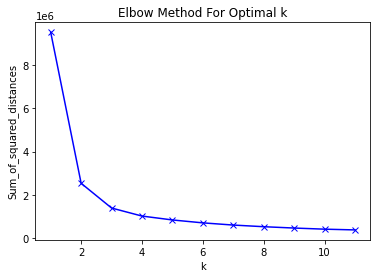

/home/snath/polybox/LAMACLIMA/LCLM_module/cluster_background_climates.py:49: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data_ts_ctl[model][i_mon,:]=xr.open_mfdataset('/net/so4/landclim/snath/data/WP1/ts_to_t2m/wc2.1_10m_tavg_%s_g025.nc'%i_mon_lab).roll(lon=72).Band1.values[idx_l]
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` opti

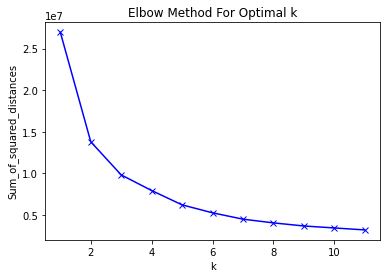

/home/snath/polybox/LAMACLIMA/LCLM_module/cluster_background_climates.py:49: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data_ts_ctl[model][i_mon,:]=xr.open_mfdataset('/net/so4/landclim/snath/data/WP1/ts_to_t2m/wc2.1_10m_tavg_%s_g025.nc'%i_mon_lab).roll(lon=72).Band1.values[idx_l]
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` opti

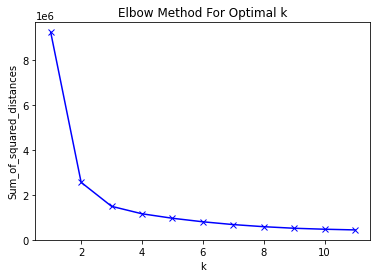

/home/snath/polybox/LAMACLIMA/LCLM_module/cluster_background_climates.py:49: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data_ts_ctl[model][i_mon,:]=xr.open_mfdataset('/net/so4/landclim/snath/data/WP1/ts_to_t2m/wc2.1_10m_tavg_%s_g025.nc'%i_mon_lab).roll(lon=72).Band1.values[idx_l]
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` opti

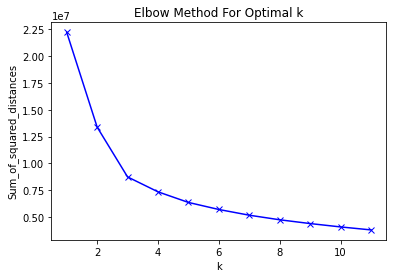

In [3]:
## Only run if pre-check on number of cluster groups necessary is needed


for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
    
    cluster_background_climates.elbow_method(model)
    
   

In [ ]:
import matplotlib.colors as mcolors

dir_data='/net/so4/landclim/snath/data/LCLM/'

labels_final = {}
k = 5

for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
    
    labels_final = cluster_bakcground_climates.cluster_final(labels_final,model,k)
    
    dir_out_data_mod=dir_data+'ts_'+model+'_idealised_g025/'
    
    joblib.dump(labels_final[model],dir_out_data_mod+'labels_final.pkl')

In [97]:
import mplotutils as mpu
from tools.gridding import norm_cos_wgt

srex_raw = xr.open_mfdataset('/net/so4/landclim/snath/data/srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc', combine='by_coords',decode_times=False)
srex_vals=srex_raw.srex_mask.values

reg_dict={'NA':[1,3,4,5],'SA':[6,7,8,9,10],'AF':[14,15,16,17],
          'EURAS':[11,12,13,18,19,20,22,23],'AUS':[25,26],'CGI':[2],
         'TIB':[21],'SEA':[24]}




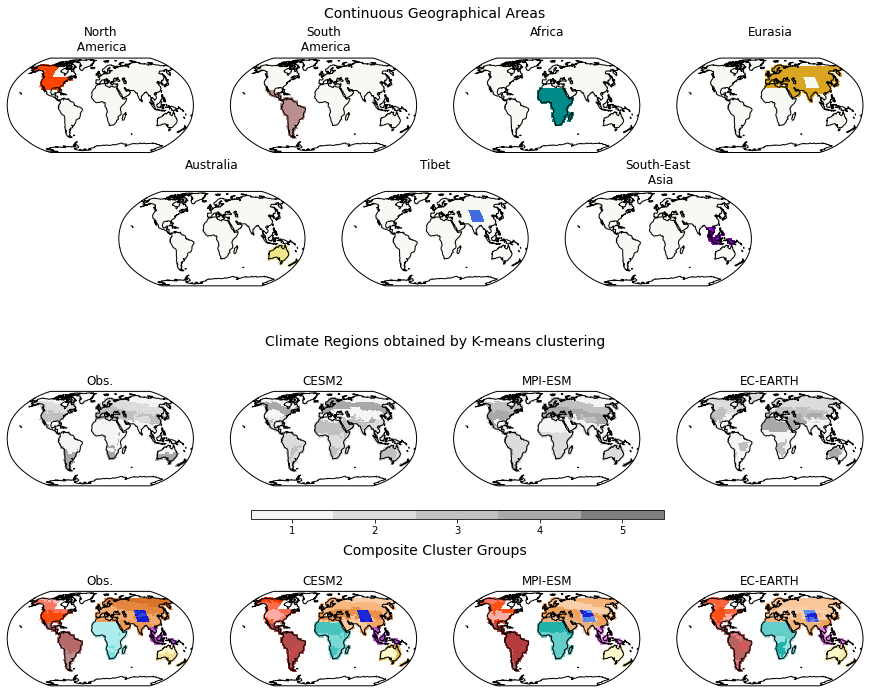

In [100]:
##Make plot cluster groups
import matplotlib as mpl
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap

n_col = 4
n_row = 4

fs_title=16

fig=plt.figure(figsize=(16, 14))
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*4+7, n_col*10, wspace=0, hspace=0.2) # create a grid for the subplots #0.12
regions=['Global','North\n America','South\n America','Africa\n','Eurasia\n','Australia\n','CGI','Tibet\n','South-East\n Asia']

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
colors_regions=['orangered','rosybrown','darkcyan','goldenrod','khaki','bleh','royalblue','darkviolet']
colors_subregions={1:['lightsalmon','lightcoral','firebrick','rosybrown','maroon','orangered','salmon'],3:['peru','peachpuff','sandybrown','chocolate'],
                      2:['lightcyan','lightseagreen','paleturquoise','mediumturquoise'],4:['darkgoldenrod','palegoldenrod','lemonchiffon','goldenrod'],
                      5:['orange','darkorange'],7:['cornflowerblue','mediumblue','royalblue','blue'],
                      8:['plum','violet','mediumorchid','darkorchid']}
colors_climate=['whitesmoke','gainsboro','silver','darkgrey','grey']

bounds = np.array([0.5, 1.5, 2.5, 3.5, 4.5,5.5])
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)

##plot geographical regions
axtitle=plt.subplot(grid[0,5:-5])
plt.title('Continuous Geographical Areas',fontsize=14,y=1.02)
plt.axis('off')

i_y=0
i=0
for i_reg in range(1,9):
    
    if i_reg==6:
        continue
    
    white=np.array([248/256, 250/256, 245/256, 1])
    color=to_rgba(colors_regions[i_reg-1])
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', np.vstack((white,color)), N=2)
    
    if i_reg<=4:
        ax = plt.subplot(grid[i+1:i+4,i_y*10:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))
    if i_reg>4:
        if i_reg==5:
            i_y=0
        
        ax = plt.subplot(grid[i+5:i+8,i_y*10+5:i_y*10+15], projection=ccrs.Robinson(central_longitude=0))
    
    y_ma = np.zeros(idx_l.shape)
    y_ma = ma.masked_array(y_ma, mask=idx_l==False)
    
    y_dummy=np.zeros(idx_l.sum())
    reg_mask=np.isin(srex_vals[idx_l],reg_dict[list(reg_dict.keys())[i_reg-1]])       
    y_dummy[reg_mask]=1

    y_ma = np.zeros(idx_l.shape)
    y_ma = ma.masked_array(y_ma, mask=idx_l==False)
    y_ma[idx_l]=y_dummy

    ax.coastlines()
    mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=mymap,vmin=0,vmax=1,transform=ccrs.PlateCarree(),rasterized=True)

    #axtitle=plt.subplot(grid[1,i_y*10:i_y*10+10])
    plt.title(regions[i_reg],fontsize=12,y=1.01)
    #plt.axis('off')
    
    i_y+=1


##plot climate regions
i_y=0
i=10
axtitle=plt.subplot(grid[9,5:-5])
plt.title('Climate Regions obtained by K-means clustering',fontsize=14,y=0.02)
plt.axis('off')

mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', np.vstack(([to_rgba(col) for col in colors_climate])))
sm = mpl.cm.ScalarMappable(cmap=mymap, norm=norm)
sm.set_array([])

axcbar=plt.subplot(grid[13:15,2:50])
plt.colorbar(sm,orientation='horizontal',ticks=[1,2,3,4,5],aspect=45)
plt.axis('off')

for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
    
    model_label=model
    if model=='Obs':
        model_label='Obs.'
    ax = plt.subplot(grid[i+1:i+4,i_y*10:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))
    
    y_ma = np.zeros(idx_l.shape)
    y_ma = ma.masked_array(y_ma, mask=idx_l==False)

    y_ma[idx_l]=labels[model].astype(int)


    ax.coastlines()
    mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=mymap,norm=norm,transform=ccrs.PlateCarree(),rasterized=True)
    
    #axtitle=plt.subplot(grid[i,i_y*10:i_y*10+10])
    plt.title(model_label)
    #plt.axis('off')
    i_y+=1    

axtitle=plt.subplot(grid[15,5:-5])
plt.title('Composite Cluster Groups',fontsize=14,y=-0.32)
plt.axis('off')


i=16
i_y=0
for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
    
    model_label=model
    if model=='Obs':
        model_label='Obs.'
    ax = plt.subplot(grid[i+1:i+4,i_y*10:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))
    
    y_ma = np.zeros(idx_l.shape)
    y_ma = ma.masked_array(y_ma, mask=idx_l==False)
    
    no_comp_cluster=len(np.unique(labels_final[model]))
    decomp_labels_final_model=np.full([idx_l.sum()],np.nan)
    
    i_six=0
    for idx_cluster in range(1,no_comp_cluster):
        
        cluster_label=idx_cluster
        if int(str(np.unique(labels_final[model])[idx_cluster])[0])==6:
            i_six+=1
            continue
        if int(str(np.unique(labels_final[model])[idx_cluster])[0])>6:
            cluster_label=idx_cluster-i_six
            
        #print(np.unique(labels_final[model])[idx_cluster])
        #print(int(str(np.unique(labels_final[model])[idx_cluster])[0]))
        decomp_labels_final_model[labels_final[model].astype(int)==int(np.unique(labels_final[model])[idx_cluster])]=int(np.unique(labels_final[model])[idx_cluster])
    
    bounds = np.arange(np.max(labels_final[model])+1)-0.5
    norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)

    color_array=[to_rgba('whitesmoke')]
    
    for i_reg in range(1,9):
        if i_reg==6:
            continue
            
        n_sub_regions=len(np.unique([i_sub_reg for i_sub_reg in labels_final[model] if int(str(i_sub_reg)[0])==i_reg]))
        #print(len(colors_subregions[i_reg]),len(list(colors_subregions[i_reg][:n_sub_regions])))
        color_array.append(list(colors_subregions[i_reg][::-1][:n_sub_regions+1]))
    
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', np.vstack(([to_rgba(col) for col in np.hstack((color_array))])))

    
    
    y_ma[idx_l]= decomp_labels_final_model#.astype(int)


    ax.coastlines()
    mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma, cmap=mymap,norm=norm,transform=ccrs.PlateCarree(),rasterized=True)
    
    #axtitle=plt.subplot(grid[i,i_y*10:i_y*10+10])
    plt.title(model_label)
    #plt.axis('off')
    i_y+=1

plt.savefig('/net/so4/landclim/snath/LCLM-mod_Pictures/Comp_cluster_groups.pdf')


# Train GAM for Tsurf

In [ ]:
##Train final LCLM GAM

from scipy.stats import pearsonr

lam_sel={}
n_splines_sel={}
scores_lclm={}
lclm_gam={}

'''
-----------------------------
-----------------------------
Var1: lon                    |
Var2: lat                    |
Var3: orography              |
Var4: forest percentage      |      
-----------------------------
'''

for model in ['Obs']:
    
    
    lam_sel[model]={}
    n_splines_sel[model]={}
    lclm_gam[model]={}
    
    scores_lclm[model]={}

    for var in ['ts_local']:
        


        scores_lclm[model][var]={}
        lclm_gam[model][var]={}
        lam_sel[model][var]=np.zeros(12)
        n_splines_sel[model][var]=np.zeros(12)


        for i_mon in tqdm(range(12)):
            
            if model=='Obs':
                
                y = np.vstack((np.nanmean(data[model][var][0].reshape(-1,12,idx_l.sum())[:,i_mon,:],axis=0),
                               np.zeros([1,idx_l.sum()])))
                
                X = np.hstack(([data_lc[model][key][0].reshape(-1,1) for key in data_lc[model].keys() if key in ['lon','lat','orog','treeFrac']]))
                X=np.vstack((X.reshape(-1,idx_l.sum(),4),X.reshape(-1,idx_l.sum(),4)))
                X[1,:,-1]=0
                X=X.reshape(-1,4)
                
            else:

                y = np.vstack((np.nanmean(data[model][var][0].reshape(-1,12,idx_l.sum())[:,i_mon,:],axis=0),
                               np.nanmean(data[model][var][1].reshape(-1,12,idx_l.sum())[:,i_mon,:],axis=0),
                               np.zeros([1,idx_l.sum()])))
                y = np.nan_to_num(y)
                X = np.hstack(([block_cv.create_training_set(data[model][var],data_lc[model][key],key,i_mon)for key in data_lc[model].keys() if key in ['lon','lat','orog','treeFrac']]))
                           
            labels=labels_final[model]

            print('Performing spatial cv of GAM for', model,', on ',X.shape[1],' input variables')
            
            scores_lclm[model][var][i_mon]={}
            lclm_gam[model][var][i_mon]={}
            weights=np.where(np.sqrt((y.flatten()-np.nanmean(y.flatten()))**2).reshape(-1,1)>1.5,0.6,1)
            weights[np.squeeze(np.argwhere(np.sqrt((y.flatten()-np.nanmean(y.flatten()))**2)>2))]=0.3
            
            lambdas=[0.001,0.01,0.1,1]
            n_splines=[5,7,8,9]
            
            for lam in lambdas:
                scores_lclm[model][var][i_mon][lam]={}

                for nsplines in n_splines:

                    plot_switch=False
                    if i_mon==11 and lam==1 and nsplines==9:
                        plot_switch=True
                    
                    if model=='Obs':
                        scores_lclm[model][var][i_mon][lam][nsplines]=block_cv.spatial_cv_obs(LinearGAM(te(0,1,3,by=2),lam=lam,n_splines=nsplines),X,y,X.shape[1],labels,
                                                                                 int(len(np.unique(labels))),weights)
                    else:
                        scores_lclm[model][var][i_mon][lam][nsplines]=block_cv.spatial_cv(LinearGAM(te(0,1,3,by=2),lam=lam,n_splines=nsplines),X,y,X.shape[1],labels,
                                                                                 int(len(np.unique(labels))),weights)
     
            if model=='Obs':           
                lam_sel[model][var][i_mon],n_splines_sel[model][var][i_mon]=block_cv.GridSearch_sel_obs(scores_lclm[model][var][i_mon],np.unique(labels),lambdas,n_splines)
            else:
                lam_sel[model][var][i_mon],n_splines_sel[model][var][i_mon]=block_cv.GridSearch_sel(scores_lclm[model][var][i_mon],np.unique(labels),lambdas,n_splines)

            lclm_gam[model][var][i_mon] = LinearGAM(te(0,1,3,by=2),lam=lam_sel[model][var][i_mon],
                                                    n_splines=int(n_splines_sel[model][var][i_mon])).fit(X.reshape(-1,idx_l.sum(),4)[:,~np.isnan(y[0,:]),:].reshape(-1,4), 
                                                                                                         y[:,~np.isnan(y[0,:])].flatten(),weights=np.nan_to_num(weights.reshape(2,-1)[:,~np.isnan(y[0,:])]))

    if var=='ts_local':
        
        dir_out_data_mod=dir_data+'ts_'+model+'_idealised_g025/'
        if not os.path.exists(dir_out_data_mod):
            os.makedirs(dir_out_data_mod)
            print('created dir:',dir_out_data_mod)
    
    else:
    
        dir_out_data_mod=dir_data+'tsmn_tsmx_'+model+'_idealised_g025/'
        if not os.path.exists(dir_out_data_mod):
            os.makedirs(dir_out_data_mod)
            print('created dir:',dir_out_data_mod)

    joblib.dump(lclm_gam[model],dir_out_data_mod+model+'_FRST_CROP_GAM_final.pkl')
    joblib.dump(scores_lclm[model],dir_out_data_mod+model+'_FRST_CROP_GAM_CV_results.pkl')
    
    

## Calibration Plots

### First load models

In [99]:
## get ts_mean CV results
from sklearn.externals import joblib 
import joblib as job
import importlib
importlib.reload(block_cv)

dir_data='/net/so4/landclim/snath/data/LCLM/'

lclm_gam={}
lam_sel={}
n_splines_sel={}
labels = {}
labels_final = {}

lambdas=[0.001,0.01,0.1,1]
n_splines=[5,7,8,9]

for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
    
    lam_sel[model]={}
    n_splines_sel[model]={}
    
    labels_final[model] = job.load(dir_data+'ts_'+model+'_idealised_g025/labels_final.pkl')
    labels[model] = job.load(dir_data+'ts_'+model+'_idealised_g025/labels.pkl')
    
    for var in ['ts_local']:
    
        if var=='ts_local':

            dir_in_data_mod=dir_data+'ts_'+model+'_idealised_g025/'

        else:

            dir_in_data_mod=dir_data+'tsmn_tsmx_'+model+'_idealised_g025/'
       
        scores_lclm_ts=joblib.load(dir_in_data_mod+model+'_FRST_CROP_GAM_CV_results.pkl')
        lclm_gam[model]=job.load(dir_in_data_mod+model+'_FRST_CROP_GAM_final.pkl')

        lam_sel[model][var]={}
        n_splines_sel[model][var]={}

        for i_mon in tqdm(range(12)):
            
            if model=='Obs':
                lam_sel[model][var][i_mon],n_splines_sel[model][var][i_mon]=block_cv.GridSearch_sel_obs(scores_lclm_ts[var][i_mon],np.unique(labels_final[model]),lambdas,n_splines)
            else:
                lam_sel[model][var][i_mon],n_splines_sel[model][var][i_mon]=block_cv.GridSearch_sel(scores_lclm_ts[var][i_mon],np.unique(labels_final[model]),lambdas,n_splines)


/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: Mean of empty slice
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: Mean of empty slice


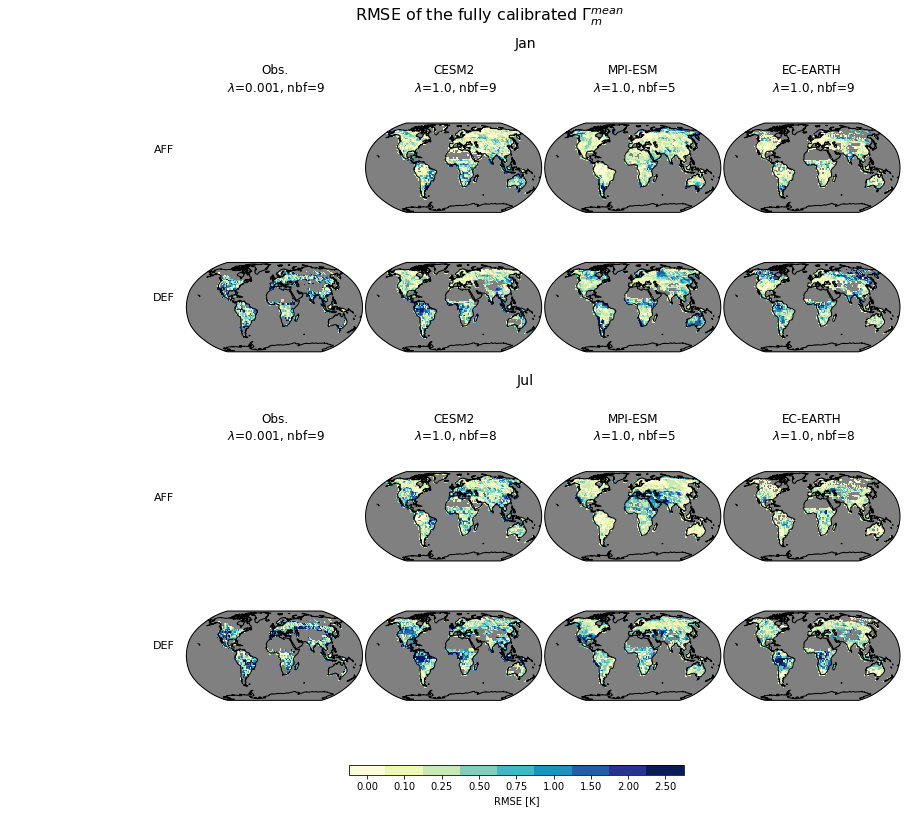

In [113]:
import matplotlib.colors as mcolors
import joblib
dir_data='/net/so4/landclim/snath/data/LCLM/'
var='ts_mean'
lclm_gam={}

n_col = 4
n_row = 2

fs_title=16

fig=plt.figure(figsize=(16, 14))
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*5+12, n_col*10+10, wspace=0.2, hspace=0.2) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


axtitle=plt.subplot(grid[0,4:])
plt.title(r'RMSE of the fully calibrated $\Gamma^{mean}_{m}$',y=0.52,fontsize=16)
plt.axis('off')

colormap=plt.get_cmap('YlGnBu')
colormap.set_bad(color = 'grey')

bounds = [-0.05,0.05,0.15,0.35,0.65,0.85,1.15,1.85,2.15,2.85]
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)

for i_mon in [0,6]:
    
    i_y=1
    for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
        
        dir_in_data_mod=dir_data+'ts_'+model+'_idealised_g025/'
        lclm_gam[model]=joblib.load(dir_in_data_mod+model+'_FRST_CROP_GAM_final.pkl')

        
        
        if i_mon==0:
            i=2
        elif i_mon==6:
            i=12
        
        if i_mon==6 and model=='Obs':
            axcbar=plt.subplot(grid[20:,17:40]) 
            cbar=plt.colorbar(mesh_1,orientation='horizontal',aspect=35,ticks=[0,0.1,0.25,0.5,0.75,1,1.5,2,2.5])
            cbar.ax.set_xlabel('RMSE [K]')
            plt.axis('off')
        
        for i_lab in range(2):
        

            model_label=model
            if model=='Obs':
                model_label='Obs.'

            if i_lab==0:
                axtitle=plt.subplot(grid[i,i_y*10:i_y*10+10])
                if model=='Obs':
                    plt.title('Obs.' +'\n' +r' $\lambda$=%.3f, nbf=%i'%(lam_sel[model]['ts_local'][i_mon], n_splines_sel[model]['ts_local'][i_mon]),y=0.52)
                    i+=4
                    plt.axis('off')
                    continue
                    
                else:
                    
                    if model=='EC-EARTH' and i_mon==0:
                        plt.title(model+'\n' +r' $\lambda$=%.1f, nbf=%i'%(lam_sel[model]['ts_local'][i_mon],
n_splines_sel[model]['ts_local'][i_mon]),y=0.52)
                    else:
                        plt.title(model+'\n' +r' $\lambda$=%.1f, nbf=%i'%(lam_sel[model]['ts_local'][i_mon],
n_splines_sel[model]['ts_local'][i_mon]),y=0.52)
                    
                    plt.axis('off')

           
            if model=='Obs' and i_lab==1:
                X = np.hstack(([data_lc[model][key].reshape(-1,1) for key in data_lc[model].keys() if key in ['lon','lat','orog','treeFrac']]))

                y=lclm_gam[model]['ts_local'][i_mon].predict(X)
                y[np.isnan(np.nanmean(data[model][var][0].reshape(-1,12,idx_l.sum())[:,i_mon,:],axis=0))]=np.nan

                
                y_ma = np.zeros(idx_l.shape)
                y_ma = ma.masked_array(y_ma, mask=idx_l==False)

                y_ma[idx_l]=np.array([[block_cv.calculate_rmse_gp(y[i_grid],
                                                        np.nanmean(data[model][var][0].reshape(-1,12,idx_l.sum())[:,i_mon,i_grid]))\
                                       for i_grid in np.arange(idx_l.sum())]]).flatten()

            elif model!='Obs' and i_lab in [0,1]:
                X = np.hstack(([block_cv.create_prediction_set(data[model][var],data_lc[model][key],key,i_lab,i_mon)for key in data_lc[model].keys() if key in ['lon','lat','orog','treeFrac']]))

                y=lclm_gam[model]['ts_local'][i_mon].predict(X)
                y[np.abs(X[:,-1])<=0.01]=np.nan
                
                y_ma = np.zeros(idx_l.shape)
                y_ma = ma.masked_array(y_ma, mask=idx_l==False)
                #print(model)
                y_ma[idx_l]=np.array([[block_cv.calculate_rmse_gp(y[i_grid],
                                                        np.nanmean(data[model][var][i_lab].reshape(-1,12,idx_l.sum())[:,i_mon,i_grid]))\
                                       for i_grid in np.arange(idx_l.sum())]]).flatten()
            
            if i_lab in [0,1]:
                ax = plt.subplot(grid[i+1:i+4,i_y*10:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))

                ax.coastlines()
                mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=plt.get_cmap('YlGnBu'),transform=ccrs.PlateCarree(),rasterized=True,norm=norm)
                #ax.set_title(model_label,y=1.02,fontsize=12)
            
            
            i+=4
        i_y+=1
        
            

axtitle=plt.subplot(grid[1,8:])
plt.title(r'Jan',y=0.82,fontsize=14)
plt.axis('off')

axtitle=plt.subplot(grid[10,8:])
plt.title(r'Jul',y=0.02,fontsize=14)
plt.axis('off')

axtitle=plt.subplot(grid[4,0])
plt.title('AFF',y=0.82,fontsize=11,x=10.5)

plt.axis('off')

axtitle=plt.subplot(grid[8,0])
plt.title('DEF',y=0.52,fontsize=11,x=10.5)

plt.axis('off')


axtitle=plt.subplot(grid[14,0])
plt.title('AFF',y=0.82,fontsize=11,x=10.5)

plt.axis('off')

axtitle=plt.subplot(grid[18,0])
plt.title('DEF',y=0.52,fontsize=11,x=10.5)

plt.axis('off')

plt.savefig('/net/so4/landclim/snath/LCLM-mod_Pictures/final_gam_per.pdf')


## Block CV evaluation for performance under unseen background climates

In [ ]:
actual_error={}

for model in ['CESM2']:
    
    actual_error[model]={'rmse':{},'mae':{}}
    
    for var in ['ts_mn_local','ts_mx_local']:
        
        print('Working on, ',var,'for model: ', model)
        
        actual_error[model]['rmse'][var]=np.full([2,12,idx_l.sum()],np.nan)
        actual_error[model]['mae'][var]=np.full([2,12,idx_l.sum()],np.nan)
        
        for i_mon in tqdm(range(12)):
            

            if model=='Obs':
                
                y = np.vstack((np.nanmean(data[model][var][0].reshape(-1,12,idx_l.sum())[:,i_mon,:],axis=0),
                               np.zeros([1,idx_l.sum()])))
                
                X = np.hstack(([data_lc[model][key][0].reshape(-1,1) for key in data_lc[model].keys() if key in ['lon','lat','orog','treeFrac']]))
                X=np.vstack((X.reshape(-1,idx_l.sum(),4),X.reshape(-1,idx_l.sum(),4)))
                X[1,:,-1]=0
                X=X.reshape(-1,idx_l.sum(),4)
            else:

                y = np.vstack((np.nanmean(data[model][var][0].reshape(-1,12,idx_l.sum())[:,i_mon,:],axis=0),
                               np.nanmean(data[model][var][1].reshape(-1,12,idx_l.sum())[:,i_mon,:],axis=0),
                               np.zeros([1,idx_l.sum()])))
        
                X = np.hstack(([block_cv.create_training_set(data[model][var],data_lc[model][key],key,i_mon)for key in data_lc[model].keys() if key in ['lon','lat','orog','treeFrac']]))
                X=X.reshape(-1,idx_l.sum(),4)
            

            weights=np.where(np.sqrt((y.flatten()-np.nanmean(y.flatten()))**2).reshape(-1,1)>1.5,0.6,1)
            weights[np.squeeze(np.argwhere(np.sqrt((y.flatten()-np.nanmean(y.flatten()))**2)>2))]=0.3

            for i_reg,reg in enumerate(set(labels_final[model])):

                
                
                mask_labels=np.intersect1d(np.argwhere(labels_final[model]!=reg),np.argwhere(np.logical_or(np.abs(X[0,:,-1])>=0.01,np.abs(X[1,:,-1])>=0.01)))
               
                if model=='Obs':
                    if int(reg) in [20,30,50]:

                        mask_labels=np.vstack((mask_labels.reshape(-1,1),
                                               np.argwhere(labels_final[model]==reg)[:int(len(np.argwhere(labels_final[model]==reg))/3)].reshape(-1,1))).flatten()
                
                y_sel=y.reshape(-1,idx_l.sum())[:,mask_labels]
                weights_sel=weights.reshape(-1,idx_l.sum())[:,mask_labels]
                X_sel=X.reshape(-1,idx_l.sum(),4)[:,mask_labels,:]

                mask_nan=~np.isnan(y_sel[0,:])
                y_sel=y_sel[:,mask_nan]
                weights_sel=weights_sel[:,mask_nan]
                X_sel=X_sel[:,mask_nan,:]
                
                gam_actual=LinearGAM(te(0,1,3,by=2),lam=lam_sel[model][var][i_mon],
                                                        n_splines=int(n_splines_sel[model][var][i_mon])).fit(X_sel.reshape(-1,4), y_sel.flatten(),weights=np.nan_to_num(weights_sel))
                
                idx_bin=np.intersect1d(np.argwhere(np.logical_and(labels_final[model]==reg,~np.isnan(y.reshape(-1,idx_l.sum())[0,:]))),np.argwhere(np.logical_or(np.abs(X[0,:,-1])>=0.15,np.abs(X[1,:,-1])>=0.15)))
                #print(len(idx_bin))
                idx_bin=np.array([idx for idx in idx_bin if idx not in mask_labels])
                #print(len(idx_bin))
                
                if len(idx_bin)>0:
                    if model=='Obs':
                    
                        actual_error[model]['rmse'][var][1,i_mon,idx_bin]=block_cv.calculate_rmse_gp(gam_actual.predict(X.reshape(-1,idx_l.sum(),4)\
                                                                                      [0,idx_bin,:].reshape(-1,4)),y.reshape(-1,idx_l.sum())[0,idx_bin].flatten()).reshape(-1)
                        actual_error[model]['mae'][var][1,i_mon,idx_bin]=block_cv.calculate_mae_gp(gam_actual.predict(X.reshape(-1,idx_l.sum(),4)\
                                                                                          [0,idx_bin,:].reshape(-1,4)),y.reshape(-1,idx_l.sum())[0,idx_bin].flatten()).reshape(-1)
                    
                
                    else:
                    
                        actual_error[model]['rmse'][var][0,i_mon,idx_bin]=block_cv.calculate_rmse_gp(gam_actual.predict(X.reshape(-1,idx_l.sum(),4)\
                                                                                          [0,idx_bin,:].reshape(-1,4)),y.reshape(-1,idx_l.sum())[0,idx_bin].flatten()).reshape(-1)
                        actual_error[model]['mae'][var][0,i_mon,idx_bin]=block_cv.calculate_mae_gp(gam_actual.predict(X.reshape(-1,idx_l.sum(),4)\
                                                                                          [0,idx_bin,:].reshape(-1,4)),y.reshape(-1,idx_l.sum())[0,idx_bin].flatten()).reshape(-1)
                        actual_error[model]['rmse'][var][1,i_mon,idx_bin]=block_cv.calculate_rmse_gp(gam_actual.predict(X.reshape(-1,idx_l.sum(),4)\
                                                                                          [1,idx_bin,:].reshape(-1,4)),y.reshape(-1,idx_l.sum())[1,idx_bin].flatten()).reshape(-1)
                        actual_error[model]['mae'][var][1,i_mon,idx_bin]=block_cv.calculate_mae_gp(gam_actual.predict(X.reshape(-1,idx_l.sum(),4)\
                                                                                         [1,idx_bin,:].reshape(-1,4)),y.reshape(-1,idx_l.sum())[1,idx_bin].flatten()).reshape(-1)

        print('Saving data for: %s, %s'%(model,var))   
            
        if var=='ts_local':
            dir_out_data_mod=dir_data+'ts_'+model+'_idealised_g025/'

        else:

            dir_out_data_mod=dir_data+'tsmn_tsmx_'+model+'_idealised_g025/'
            
        joblib.dump(actual_error[model], dir_out_data_mod+'model_cv_eval_clim.pkl')



            
            

## Block CV evaluation for performance under unseen tree cover changes

In [ ]:
treefrac_bins=[[-1,-0.8],[-0.8,-0.5],[-0.5,-0.3],[-0.3,-0.15],[-0.15,-0.01],
               [0.01,0.15],[0.15,0.3],[0.3,0.5],[0.5,0.8],[0.8,1]]
extrapolated_error={}
extrapolated_error_bounds={}

for model in ['CESM2']:
    
    extrapolated_error[model]={}
    extrapolated_error_bounds[model]={}
    
    for var in ['ts_mn_local','ts_mx_local']:
        
        print('Working on, ',var,'for model: ', model)
        
        extrapolated_error[model][var]=np.full([10,12,idx_l.sum()],np.nan)

        
        for i_mon in tqdm(range(12)):
            

            if model=='Obs':
                
                y = np.vstack((np.zeros([1,idx_l.sum()]),
                              np.nanmean(data[model][var][0].reshape(-1,12,idx_l.sum())[:,i_mon,:],axis=0)))
                
                X = np.hstack(([data_lc[model][key][0].reshape(-1,1) for key in data_lc[model].keys() if key in ['lon','lat','orog','treeFrac']]))
                X=np.vstack((X.reshape(-1,idx_l.sum(),4),X.reshape(-1,idx_l.sum(),4)))
                X[0,:,-1]=0
                X=X.reshape(-1,4)
            else:

                y = np.vstack((np.nanmean(data[model][var][0].reshape(-1,12,idx_l.sum())[:,i_mon,:],axis=0),
                               np.nanmean(data[model][var][1].reshape(-1,12,idx_l.sum())[:,i_mon,:],axis=0),
                               np.zeros([1,idx_l.sum()])))
        
                X = np.hstack(([block_cv.create_training_set(data[model][var],data_lc[model][key],key,i_mon)for key in data_lc[model].keys() if key in ['lon','lat','orog','treeFrac']]))
          
            y=np.nan_to_num(y)
            X=np.nan_to_num(X)

            weights=np.where(np.sqrt((y.flatten()-np.nanmean(y.flatten()))**2).reshape(-1,1)>1.5,0.6,1)
            weights[np.squeeze(np.argwhere(np.sqrt((y.flatten()-np.nanmean(y.flatten()))**2)>2))]=0.3
            
            
            for i_reg,reg in enumerate(np.arange(1,9)):
                
                idx_labels=[i_grid for i_grid in np.arange(idx_l.sum()) if int(str(labels_final[model][i_grid])[0])==reg]
                i_lab=1
                
                for i_bin,treeFrac_bin in enumerate(treefrac_bins):
                    
                    if i_bin==5:
                        i_lab-=1
                        
                    
                    idx_test_bin=np.intersect1d(idx_labels,np.argwhere(np.logical_and(X.reshape(-1,idx_l.sum(),4)[i_lab,:,-1]>=treeFrac_bin[0],X.reshape(-1,idx_l.sum(),4)[i_lab,:,-1]<treeFrac_bin[1])))
                    
                    idx_train_bin=np.array([i_grid for i_grid in np.arange(idx_l.sum()) if i_grid not in idx_test_bin])
                    
                    y_sel=y.reshape(-1,idx_l.sum())[:,idx_train_bin]
                    weights_sel=weights.reshape(-1,idx_l.sum())[:,idx_train_bin]
                    X_sel=X.reshape(-1,idx_l.sum(),4)[:,idx_train_bin,:]
                    
                    mask_nan=~np.isnan(y_sel[0,:])
                    y_sel=y_sel[:,mask_nan]
                    weights_sel=weights_sel[:,mask_nan]
                    X_sel=X_sel[:,mask_nan,:]
                    
                    idx_test_bin=np.intersect1d(idx_test_bin,np.argwhere(~np.isnan(y.reshape(-1,idx_l.sum())[0,:])))

                    gam_actual=LinearGAM(te(0,1,3,by=2),lam=lam_sel[model][var][i_mon],
                                                            n_splines=int(n_splines_sel[model][var][i_mon])).fit(X_sel.reshape(-1,4), y_sel.flatten(),weights=np.nan_to_num(weights_sel))

                    try:
                        extrapolated_error[model][var][i_bin,i_mon,idx_test_bin]=block_cv.calculate_rmse_gp(gam_actual.predict(X.reshape(-1,idx_l.sum(),4)\
                                                                                      [i_lab,idx_test_bin,:].reshape(-1,4)),y.reshape(-1,idx_l.sum())[i_lab,idx_test_bin].flatten())
                                               
                    except:
                        pass
                    
        print('Saving data for: %s, %s'%(model,var))   
            
        if var=='ts_local':
            dir_out_data_mod=dir_data+'ts_'+model+'_idealised_g025/'

        else:

            dir_out_data_mod=dir_data+'tsmn_tsmx_'+model+'_idealised_g025/'
            
        joblib.dump(extrapolated_error[model], dir_out_data_mod+'model_cv_eval_treecov.pkl')
                                           
                                           




## Illustration of outputs

In [102]:
pdep={}
var='ts_local'

for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
    
    pdep[model]={}
    
    for i_mon in tqdm(range(12)):
        XX = lclm_gam[model][var][i_mon].generate_X_grid(term=0,meshgrid=True)
        x,y=np.meshgrid(lon_pc[:-1],lat_pc[:-1])
        
        model_label=model
        if model == 'Obs':##for pipelining Obs has a list of metadata so we just take that of an ESM
            
            model_label = 'CESM2'
        
        pdep[model][i_mon]=[]
        for z in np.unique(XX[2]):
            pdep[model][i_mon].append(lclm_gam[model][var][i_mon].predict(np.array([data_lc[model_label]['lon'],
                                                                                     data_lc[model_label]['lat'],data_lc[model_label]['orog'],np.repeat(z,idx_l.sum())]).T))
        #print(pdep)
        pdep[model][i_mon]=np.array(pdep[model][i_mon])
        
        ## mask out grid points which have no significant change at all

            
        if model == 'Obs':

            redund_pts = np.squeeze(np.argwhere(data_lc['Obs']['treeFrac'][0]>=-0.05))

        else:
            redund_pts = np.squeeze(np.argwhere(np.logical_and(data_lc[model_label]['treeFrac'][0]<=0.05,
                                               data_lc[model_label]['treeFrac'][1]>=-0.05)))

        pdep[model][i_mon][:,redund_pts] = np.nan



/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less_equal
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal


/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater_equal
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less_equal
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater_equal
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less_equal
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater_equal
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less_equal
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater_equal
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_laun

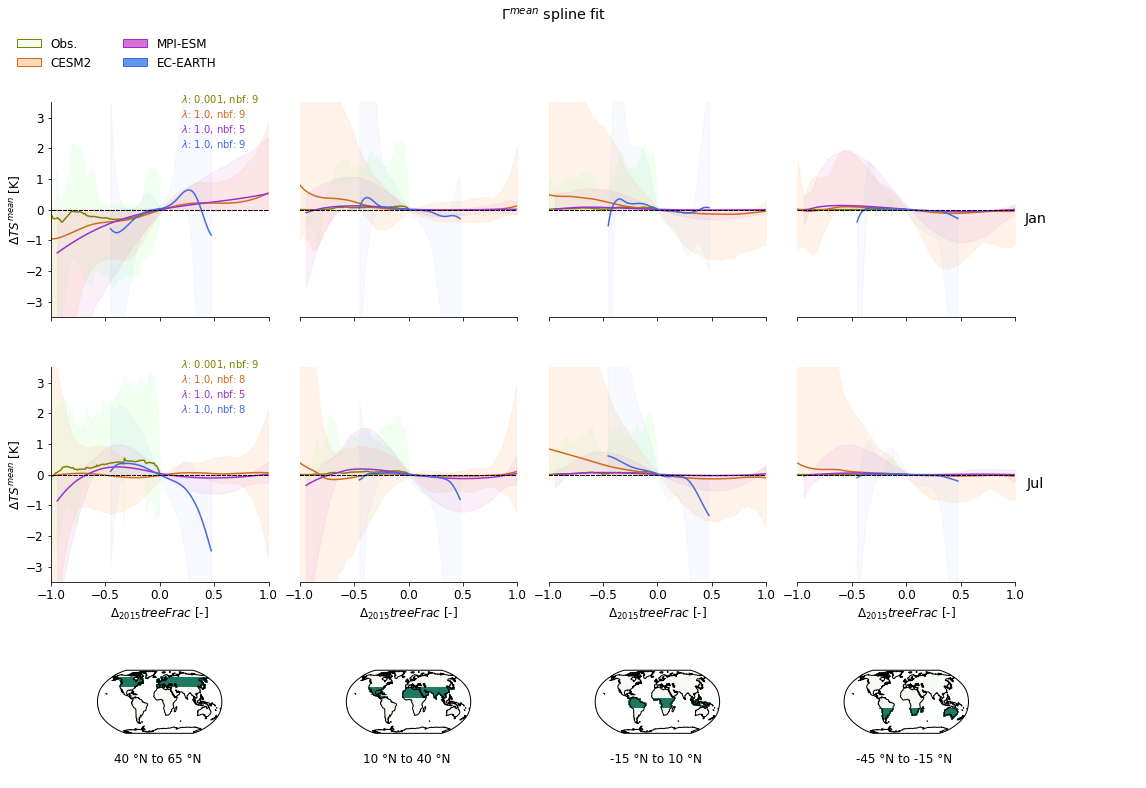

In [106]:
from scipy.stats import trim_mean, tmean
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

months=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

fs_title=18
n_row = 2
n_col = 4

plt.figure(figsize=(21, 13))

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'it'}) 
white = np.array([248/256, 250/256, 245/256, 1])
blue = np.array([30/256, 120/256, 100/256, 1])

colors = np.vstack((white,blue))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors, N=2)

grid = plt.GridSpec(n_row*6+7, n_col*6+4, wspace=-0.2, hspace=0.5) # create a grid for the subplots #0.12

colors_esm=['olive','chocolate','darkorchid','royalblue']
soft_colors_esm=['honeydew','peachpuff','orchid','cornflowerblue']
alpha_esm=[1,0.3,0.1,0.05]

axtitle=plt.subplot(grid[0:1,6:-8])
plt.title(r'$\Gamma^{mean}$ spline fit')
plt.axis('off')

i_x=2

for i_mon in [0,6]:
    
    
    i_y=1
    
    for lat_vals in zip([-45,-15,10,40][::-1],[-15,10,40,65][::-1]):
        
        ax=plt.subplot(grid[i_x:i_x+6,i_y:i_y+5])

        start_lat=np.argwhere(lat_pc==lat_vals[0])[0][0]
        stop_lat=np.argwhere(lat_pc==lat_vals[1])[0][0]

        n_gp=(stop_lat-start_lat)*(len(lon_pc)-1)

        for i_mod,model in enumerate(['Obs','CESM2','MPI-ESM','EC-EARTH']):
            
            if model=='Obs':
                mask_nan=np.isnan(data[model]['ts_mean'][0][i_mon,:])
                pdep[model][i_mon][:,mask_nan]=np.nan
                for i in range(pdep[model][i_mon].shape[0]):
                    pdep[model][i_mon][i,np.argwhere(pdep[model][i_mon][i,:]>=5)]=np.nan
                    pdep[model][i_mon][i,np.argwhere(pdep[model][i_mon][i,:]<=-5)]=np.nan

            
            XX = lclm_gam[model][var][i_mon].generate_X_grid(term=0,meshgrid=True)
        
            y_sel=np.zeros([len(np.unique(XX[2])),(stop_lat-start_lat),(len(lon_pc)-1)])
            
            
            for i in range(len(np.unique(XX[2]))):
                y_ma = np.zeros(idx_l.shape)
                y_ma = ma.masked_array(y_ma, mask=idx_l==False)
                
                
                y_ma[idx_l]=pdep[model][i_mon][i,:]
                
                y_sel[i,:,:]=y_ma[start_lat:stop_lat,:]

            y_sel=y_sel.reshape(len(np.unique(XX[2])),-1)
            
            ax.plot(np.unique(XX[2]),np.vstack(([trim_mean(y_sel[i,~np.isnan(y_sel[i,:])],0.05,axis=0) for i in range(y_sel.shape[0])])),
                                      color=colors_esm[i_mod])    
            ax.fill_between(np.unique(XX[2]),np.nanquantile(y_sel,0.05,axis=1),np.nanquantile(y_sel,0.95,axis=1),color=soft_colors_esm[i_mod],alpha=alpha_esm[i_mod])
            ax.axhline(y=0,xmin=-1,xmax=1,color='k',linestyle='--',linewidth='1')
            if 65 in lat_vals:
                if model=='Obs':
                    ax.text(0.2, 3.5-i_mod/2, r'$\lambda$: %.3f, nbf: %i'%(lam_sel[model][var][i_mon],
                                                  n_splines_sel[model][var][i_mon]),color=colors_esm[i_mod],fontsize=10,zorder=10)
                elif model=='EC-EARTH':
                    if i_mon==0:
                        ax.text(0.2, 3.5-i_mod/2, r'$\lambda$: %.1f, nbf: %i'%(lam_sel[model][var][i_mon],
                                                  n_splines_sel[model][var][i_mon]),color=colors_esm[i_mod],fontsize=10,zorder=10)
                    elif i_mon==3:
                        ax.text(0.2, 3.5-i_mod/2, r'$\lambda$: %.2f, nbf: %i'%(lam_sel[model][var][i_mon],
                                                  n_splines_sel[model][var][i_mon]),color=colors_esm[i_mod],fontsize=10,zorder=10)

                    elif i_mon==6:
                        ax.text(0.2, 3.5-i_mod/2, r'$\lambda$: %.1f, nbf: %i'%(lam_sel[model][var][i_mon],
                                                  n_splines_sel[model][var][i_mon]),color=colors_esm[i_mod],fontsize=10,zorder=10)

                else:

                    ax.text(0.2, 3.5-i_mod/2, r'$\lambda$: %.1f, nbf: %i'%(lam_sel[model][var][i_mon],
                                                  n_splines_sel[model][var][i_mon]),color=colors_esm[i_mod],fontsize=10,zorder=10)

        plt.xlim(-1,1)
        plt.ylim(-3.5,3.5)
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
            
        if 65 in lat_vals:
            plt.ylabel(r'$\Delta TS^{mean}$ [K]')
        

        ax.tick_params(labelbottom=False)
        
        if i_mon==6:
            ax.tick_params(labelbottom=True)
            plt.xlabel(r'$\Delta_{2015}treeFrac$ [-]')
            
        
        if 65 not in lat_vals:
            ax.spines['left'].set_visible(False)
            ax.tick_params(labelleft=False)
            ax.tick_params(left=False)
            
        if i_mon==6:
            axreg=plt.subplot(grid[i_x+8:i_x+13,i_y:i_y+5],projection=ccrs.Robinson(central_longitude=0))
            y_ma = np.zeros(idx_l.shape)
            y_ma[start_lat:stop_lat,:]=1
            y_ma = ma.masked_array(y_ma, mask=idx_l==False)
            axreg.coastlines()
            mesh_1=axreg.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=mymap,vmin=0,vmax=1,transform=ccrs.PlateCarree(),rasterized=True)
      
            plt.title('%i °N to %i °N \n'%(lat_vals[0],lat_vals[1]),rotation=0,fontsize=12,y=-0.8)
    
            
        i_y+=6
        
    i_x+=7



axlegend=plt.subplot(grid[0,:2])
plt.legend([Patch(edgecolor='olive',facecolor='honeydew'),
            Patch(edgecolor='chocolate',facecolor='peachpuff')],
       ['Obs.','CESM2'],frameon=False,fontsize=12)
plt.axis('off')     
axlegend=plt.subplot(grid[0,4:5])
plt.legend([Patch(edgecolor='darkorchid',facecolor='orchid'),
           Patch(edgecolor='royalblue',facecolor='cornflowerblue')],['MPI-ESM','EC-EARTH'],frameon=False,fontsize=12)
plt.axis('off')     

axtext=plt.subplot(grid[4,-2])
plt.title('Jan',x=-1,y=-1.02)
plt.axis('off')
    
axtext=plt.subplot(grid[11,-2])
plt.title('Jul',x=-1,y=-1.02)
plt.axis('off')

plt.savefig('/net/so4/landclim/snath/LCLM-mod_Pictures/part_dep.pdf')
